In [1]:
%reset -f

import warnings
warnings.filterwarnings(action="ignore")

from preprocess_images import *
from cnn_functions import *

# to compute time of pipeline
from time import time, strftime, gmtime

import pandas as pd
from os import listdir

from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions


%matplotlib inline
%autosave 300

Autosaving every 300 seconds


##### Setting paths

In [2]:
# Starting time
t0 = time()

input_path = "./dataset/cleaned/"
path_images = "./dataset/images/"
input_filename = "data_images.csv"
input_file = "{}{}".format(input_path, input_filename)

image_features_path = "./dataset/image_features/"

In [3]:
list_photos = [file for file in listdir(path_images)]
print(len(list_photos))

1050


##### Loading the dataset containing information about the images

In [4]:
data_images = pd.read_csv(input_file)
data_images.head()

,product_name,image_path,category,target
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


# CNN

In this notebook, we are going to generate **features** for each of 1050 images that we have. These features will be generated using a CNN Transfer Learning algorithm.

We are going to use a pre-trained image classification Convolutional Neural Network called VGG16.

VGG16 will give each image features.

Then, we will use a KMeans clustering on these **features** to separate the images into 7 categories.

We will display the clusters compared to the real categories using a 2D representation of t-SNE.


#### Getting the list of categories and checking the dataset.

In [5]:
list_labels = data_images["category"].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [6]:
display(data_images.groupby("target").count())
print("The data is balanced !")

,product_name,image_path,category
target,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


The data is balanced !


### Displaying some example of images per category

Home Furnishing
-------
For this category, we have 150 images.


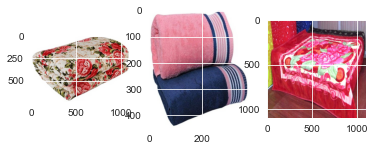

Baby Care
-------
For this category, we have 150 images.


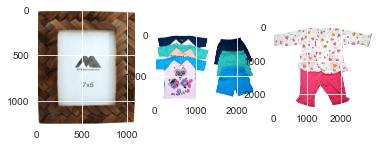

Watches
-------
For this category, we have 150 images.


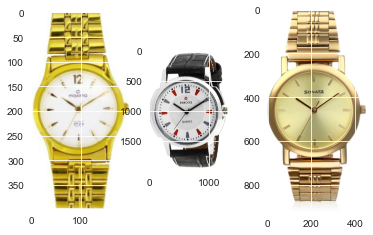

Home Decor & Festive Needs
-------
For this category, we have 150 images.


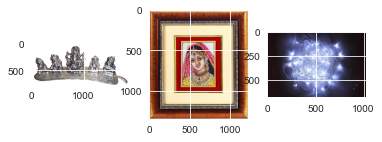

Kitchen & Dining
-------
For this category, we have 150 images.


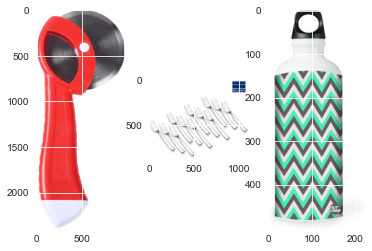

Beauty and Personal Care
-------
For this category, we have 150 images.


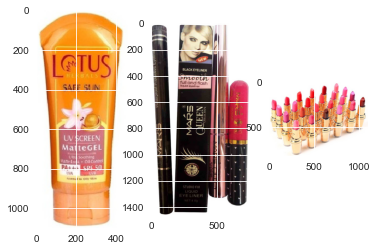

Computers
-------
For this category, we have 150 images.


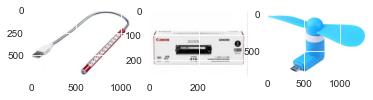

In [7]:
n_categories = len(list_labels)
n_photos = len(list_photos)

display_images_per_category(list_labels, data_images, path_images, "image_path", "category", list_photos)

Though 7 categories do not enable to completely separate the products, we have images that are correctly labeled.

### Trying VGG16 classification for one image

In [8]:
filename = path_images + list_photos[0]
img = Image.open(filename)

# Displaying the image
#img.show()

In [9]:
filename

'./dataset/images/009099b1f6e1e8f893ec29a7023153c4.jpg'

In [10]:
data_images[data_images["image_path"] == list_photos[0]]

,product_name,image_path,category,target
280,"palito PLO 166 Analog Watch - For Girls, Women",009099b1f6e1e8f893ec29a7023153c4.jpg,Watches,6


#### Preparing mapping of categories according to label number

In [11]:
mapper = data_images[["category", "target"]].drop_duplicates().sort_values(by="target").reset_index(drop=True)
mapper

,category,target
0,Baby Care,0
1,Beauty and Personal Care,1
2,Computers,2
3,Home Decor & Festive Needs,3
4,Home Furnishing,4
5,Kitchen & Dining,5
6,Watches,6


In [12]:
mapping_categories = {row["target"]: row["category"] for i, row in mapper.iterrows()}
mapping_categories

{0: 'Baby Care',
 1: 'Beauty and Personal Care',
 2: 'Computers',
 3: 'Home Decor & Festive Needs',
 4: 'Home Furnishing',
 5: 'Kitchen & Dining',
 6: 'Watches'}

#### Using VGG16 pre-Trained Model as Classifier


In [13]:
image = prepare_image_as_input(list_photos[0], path_images)

In [14]:
# load the trained model implemented in Keras
vgg = VGG16()

In [15]:
# predict the probability across all output classes (amongst the 1000 classes of ImageNet)
y = vgg.predict(image)

# retrieve the most likely result, e.g. highest probability
label = decode_predictions(y)

# Displays the top 3 most probable classes for the image
print('Top 3 :', decode_predictions(y, top=3)[0])

label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

1/1 [==============================] - 0s 442ms/step
Top 3 : [('n03706229', 'magnetic_compass', 0.40459), ('n02708093', 'analog_clock', 0.2189646), ('n03314780', 'face_powder', 0.059647042)]
magnetic_compass (40.46%)


We took the image of a watch and we can see that VGG16 classified the image not so badly.

# I - Preprocessing the images using CNN Transfert Learning

Now, we will extract features for each image using VGG16

### 1) Using VGG16 as a Feature Extractor Preprocessor
* We build a model using VGG16 pre-trained and we remove output layers so that we get for each image a list of features.
* For each image, we get a vector containing 4096 features

In [16]:
vgg_features_model = build_vgg_features()
vgg_features_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Making features for all the images

In [17]:
vgg_features_by_img, vgg_features_all = get_features(data_images, "image_path", path_images, vgg_features_model)
save_features(image_features_path, "vgg_features_by_img.npz", vgg_features_by_img)
save_features(image_features_path, "vgg_features_all.npz", vgg_features_all)

  0%|          | 0/1050 [00:00<?, ?it/s]

1/1 [==============================] - 0s 175ms/step


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 198ms/step


In [18]:
vgg_features_by_img = load_features(image_features_path, "vgg_features_by_img.npz")
vgg_features_all = load_features(image_features_path, "vgg_features_all.npz")

## II - Reducing dimensions and visualization

### PCA
* PCA generates uncorrelated features, to reduce the dimension of the dataset while keeping a high explained variance (99% in our case).
* We will get a better separation of the data when using t-SNE later on and better processing times.

In [19]:
feat_pca = get_pca_for_features(vgg_features_all)

Shape of dataset before PCA :  (1050, 4096)
Shape of dataset after PCA with 99% of explained variance :  (1050, 803)


### t-SNE
* Reducing the dimension of the dataset to 2 t-SNE components to get a 2D visualization of the images.

In [20]:
X_tsne, df_tsne = get_tsne(feat_pca, data_images, "category")

C:\Users\oumei\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


### Visual analysis : displaying t-SNE according to the images' categories
* We can see below that the SIFT method doesn't enable us to separate the categories of the products.

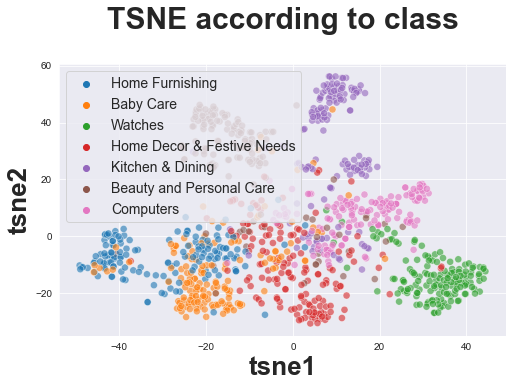

In [21]:
display_tsne(df_tsne, "class")

### Comparing real categories and the clusters

####  Creating a clustering from t-SNE

In [22]:
cls = clustering_tsne(X_tsne)
df_tsne = add_cluster_tsne(df_tsne, cls)

(1050, 4)


####  Displaying the images according to their cluster and computing ARI real categories and the cluster categories
* We get a correct ARI score of 40%.

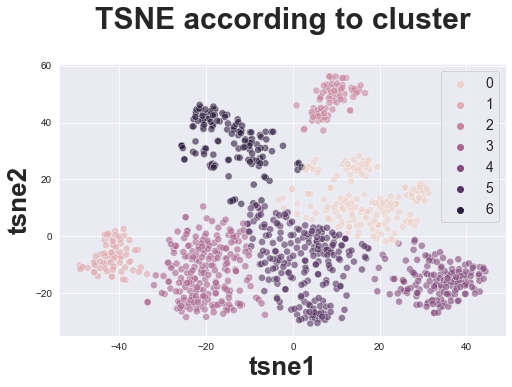

ARI :  0.466


In [23]:
display_tsne(df_tsne, "cluster")
print_ari_score(labels=data_images["target"], cls=cls)

## Conclusion
Classifying the products based on their images and using CNN and Transfer Learning algorithms seems promising for our classification model.

In [24]:
# End of notebook time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))

computing time : 366.848681 sec
computing time : 00:06:06
